# Ames Housing Sales Price Model

### Paul Schimek

### Exploratory Data Analysis & Feature Engineering

In [1]:
import numpy as np
import pandas as pd
import patsy
import dill as pickle

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler;

import statsmodels.api as sm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

In [2]:
# %config InlineBackend.figure_format = 'retina'
# %matplotlib inline

Read training data and check for nulls.

In [3]:
df = pd.read_csv('./datasets/train.csv')

In [4]:
df.isna().sum()

Id                   0
PID                  0
MS SubClass          0
MS Zoning            0
Lot Frontage       330
Lot Area             0
Street               0
Alley             1911
Lot Shape            0
Land Contour         0
Utilities            0
Lot Config           0
Land Slope           0
Neighborhood         0
Condition 1          0
Condition 2          0
Bldg Type            0
House Style          0
Overall Qual         0
Overall Cond         0
Year Built           0
Year Remod/Add       0
Roof Style           0
Roof Matl            0
Exterior 1st         0
Exterior 2nd         0
Mas Vnr Type        22
Mas Vnr Area        22
Exter Qual           0
Exter Cond           0
                  ... 
Half Bath            0
Bedroom AbvGr        0
Kitchen AbvGr        0
Kitchen Qual         0
TotRms AbvGrd        0
Functional           0
Fireplaces           0
Fireplace Qu      1000
Garage Type        113
Garage Yr Blt      114
Garage Finish      114
Garage Cars          1
Garage Area

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
Id                 2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         20

In [6]:
df.shape

(2051, 81)

In [7]:
# rule of thumb for the maximum number of features to include -- 45
np.sqrt(2051)

45.28796749689701

In [8]:
# print mean of SalePrice and counts for categorical columns
# first identify categorical features (some are int)
cat_features = [col for col in df.columns if 'SF' not in col and col not in ['Id','PID','Lot Frontage', 'Lot Area','Year Built',
                                                              'Year Remod/Add','SalePrice','Mas Vnr Area',
                                                              'Mo Sold','Garage Yr Blt', 'Gr Liv Area', 'Screen Porch',
                                                              'Garage Area','3Ssn Porch','Enclosed Porch','Misc Val']]
for category in cat_features:
    print('-------------------------------------------------------------')
    print(df.groupby(category)[['SalePrice']].describe(percentiles=[.5]))

-------------------------------------------------------------
            SalePrice                                                    \
                count           mean            std       min       50%   
MS SubClass                                                               
20              770.0  189305.488312   83531.300792   13100.0  160000.0   
30              101.0   94936.346535   29223.589715   12789.0   99500.0   
40                4.0  119125.000000   31967.105489   79500.0  122500.0   
45               11.0  116372.727273   15503.618346   87000.0  113000.0   
50              198.0  137270.000000   46383.634825   37900.0  129675.0   
60              394.0  239225.769036   77910.941364  129000.0  215100.0   
70               90.0  153354.455556   44642.191773   40000.0  147500.0   
75               16.0  204875.000000  114016.446182  101000.0  163500.0   
80               86.0  169569.825581   35942.161024  100000.0  165000.0   
85               28.0  154398.214286  

            SalePrice                                                    \
                count           mean            std       min       50%   
House Style                                                               
1.5Fin          218.0  136480.091743   44910.975892   37900.0  128700.0   
1.5Unf           12.0  112466.666667   21111.364166   64500.0  113000.0   
1Story         1059.0  179809.194523   81725.146760   12789.0  156000.0   
2.5Fin            6.0  243666.666667  128464.262216  104000.0  198500.0   
2.5Unf           14.0  191785.714286   87041.483100  101000.0  165500.0   
2Story          598.0  206408.963211   82240.431218   40000.0  189000.0   
SFoyer           50.0  149343.920000   31859.449693   73000.0  147500.0   
SLvl             94.0  166248.989362   37262.422556   91000.0  164750.0   

                       
                  max  
House Style            
1.5Fin       410000.0  
1.5Unf       139400.0  
1Story       611657.0  
2.5Fin       475000.0  
2.5Unf

          SalePrice                                                           
              count           mean           std       min       50%       max
Bsmt Qual                                                                     
Ex            184.0  329506.619565  98913.726643  100000.0  319900.0  611657.0
Fa             60.0  107752.166667  34059.476797   12789.0  100950.0  206900.0
Gd            864.0  202537.582176  57231.123839   73000.0  191750.0  538000.0
Po              1.0   89000.000000           NaN   89000.0   89000.0   89000.0
TA            887.0  139988.461105  41146.338180   34900.0  135900.0  475000.0
-------------------------------------------------------------
          SalePrice                                                           
              count           mean           std       min       50%       max
Bsmt Cond                                                                     
Ex              3.0  195000.000000  83216.584885  135000.0  160000.0 

              SalePrice                                                    \
                  count           mean            std       min       50%   
Bedroom AbvGr                                                               
0                   5.0  240791.800000  112755.941024  108959.0  279000.0   
1                  75.0  182388.920000   97728.321860   35000.0  176400.0   
2                 544.0  164656.601103   83527.760330   12789.0  143250.0   
3                1108.0  180627.309567   65541.485902   40000.0  166500.0   
4                 265.0  215374.792453  100848.990206   62500.0  192000.0   
5                  41.0  203885.951220   94753.252567   65000.0  180000.0   
6                  12.0  164111.333333   53099.607734  119900.0  142776.5   
8                   1.0  200000.000000            NaN  200000.0  200000.0   

                         
                    max  
Bedroom AbvGr            
0              385000.0  
1              501837.0  
2              611657.

            SalePrice                                                    \
                count           mean            std       min       50%   
Garage Qual                                                               
Ex                3.0  241000.000000  202680.166765  120500.0  127500.0   
Fa               82.0  116184.890244   41649.917097   12789.0  112000.0   
Gd               18.0  262989.277778  124483.627059   90350.0  266250.0   
Po                2.0   65000.000000    2828.427125   63000.0   65000.0   
TA             1832.0  188312.700328   77585.633898   35311.0  170000.0   

                       
                  max  
Garage Qual            
Ex           475000.0  
Fa           257076.0  
Gd           591587.0  
Po            67000.0  
TA           611657.0  
-------------------------------------------------------------
            SalePrice                                                   \
                count           mean           std       min       50% 

C:\Users\pauls\Anaconda3\envs\dsi\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\pauls\Anaconda3\envs\dsi\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


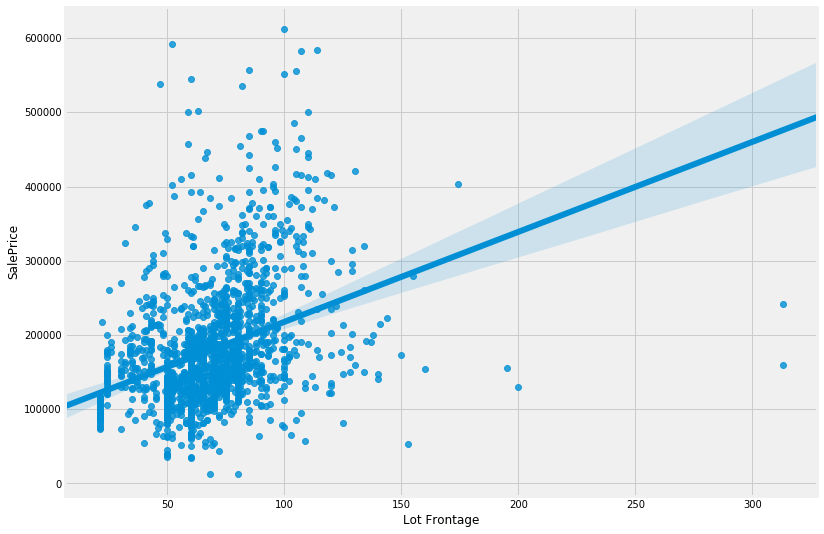

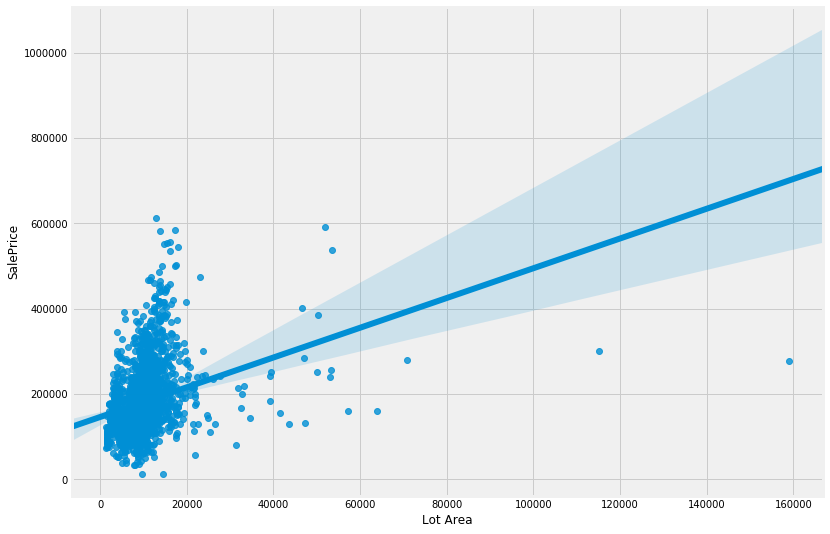

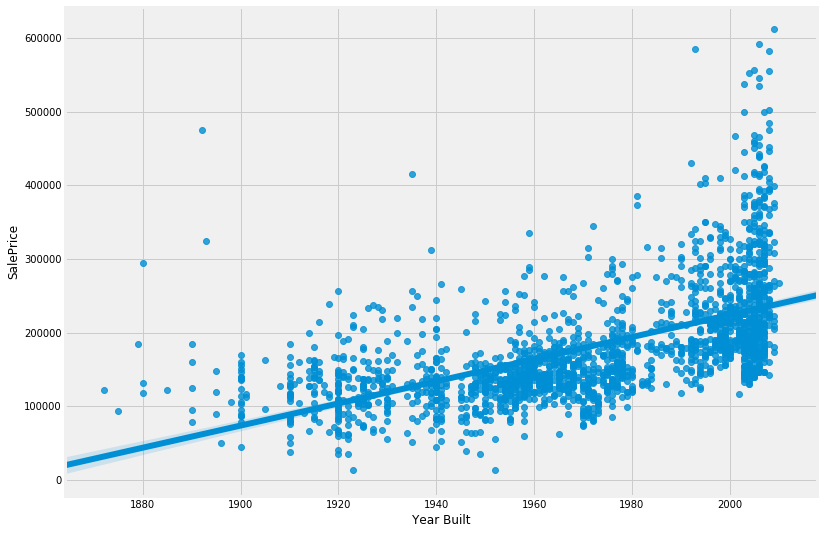

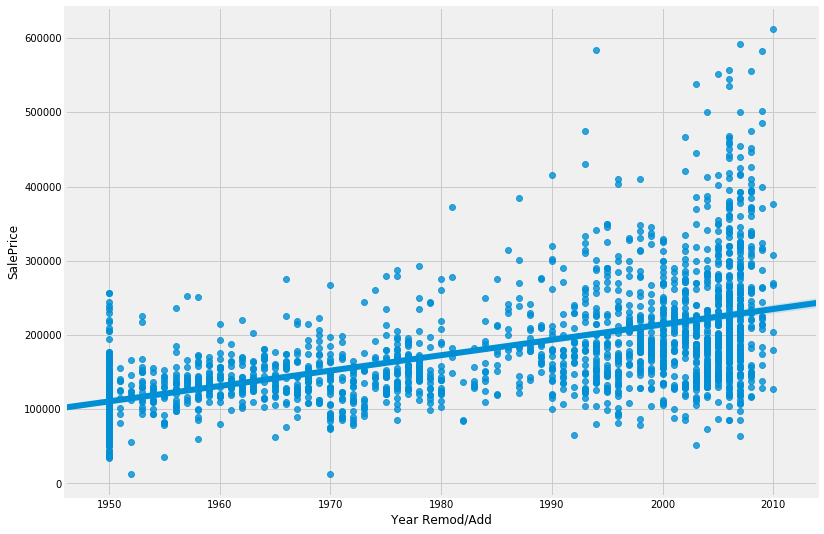

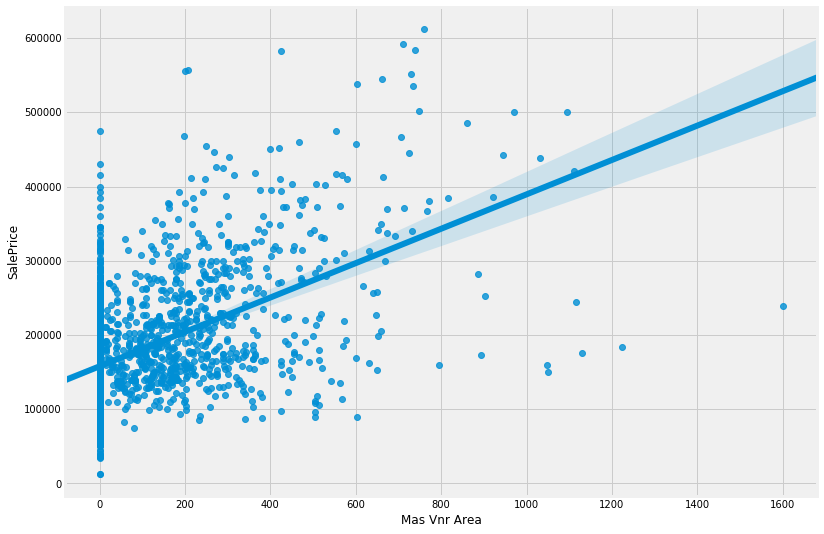

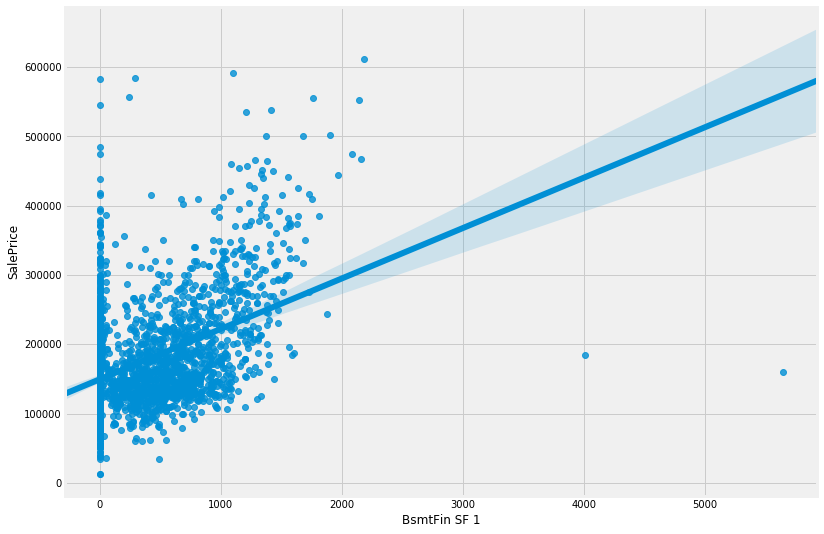

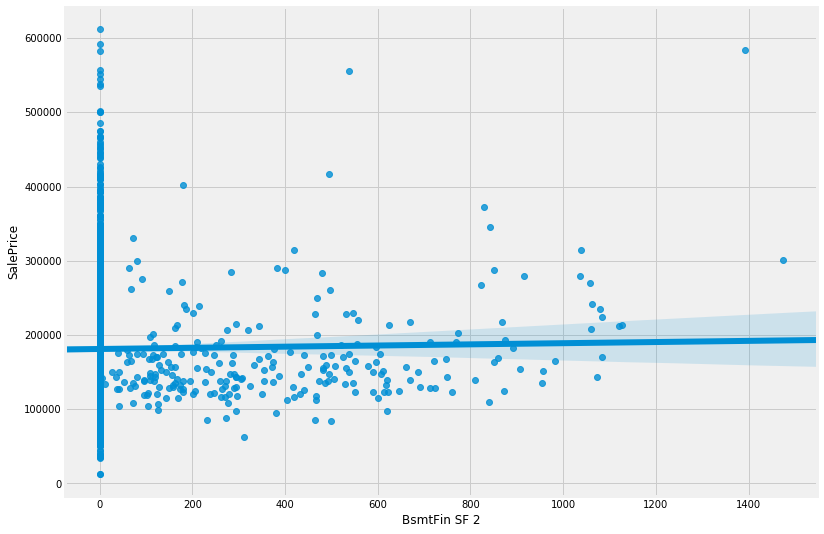

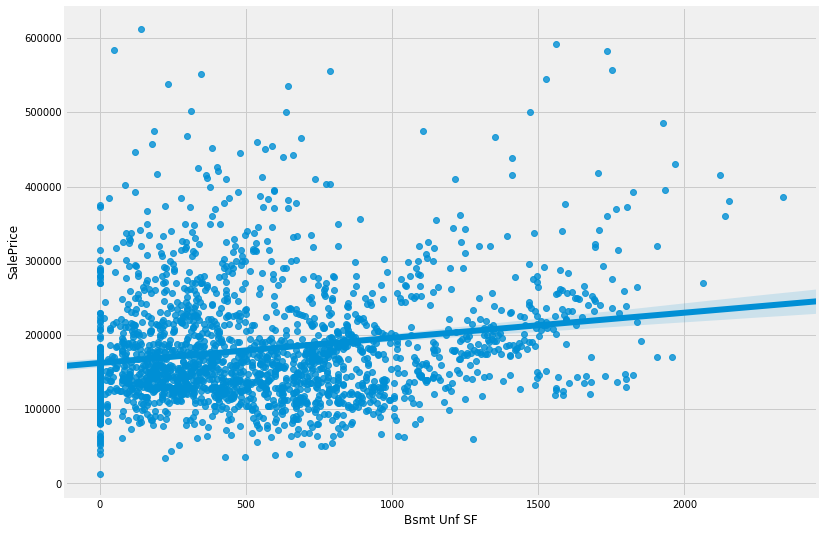

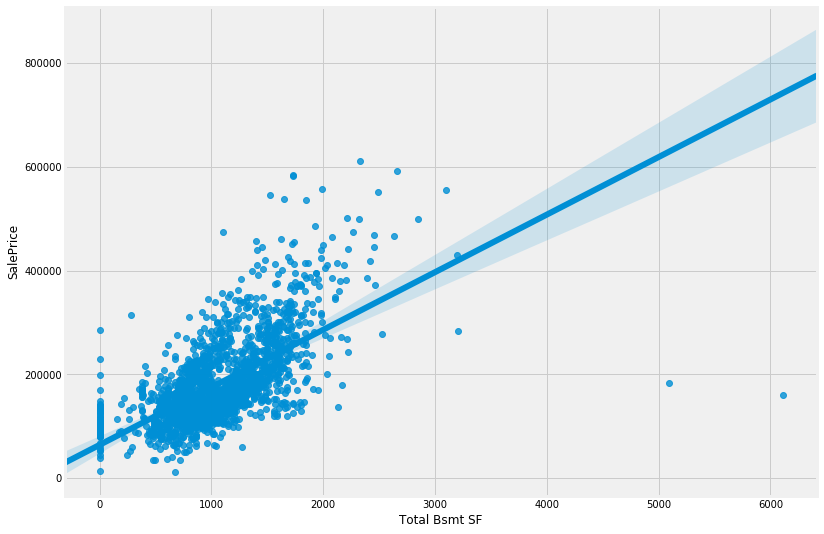

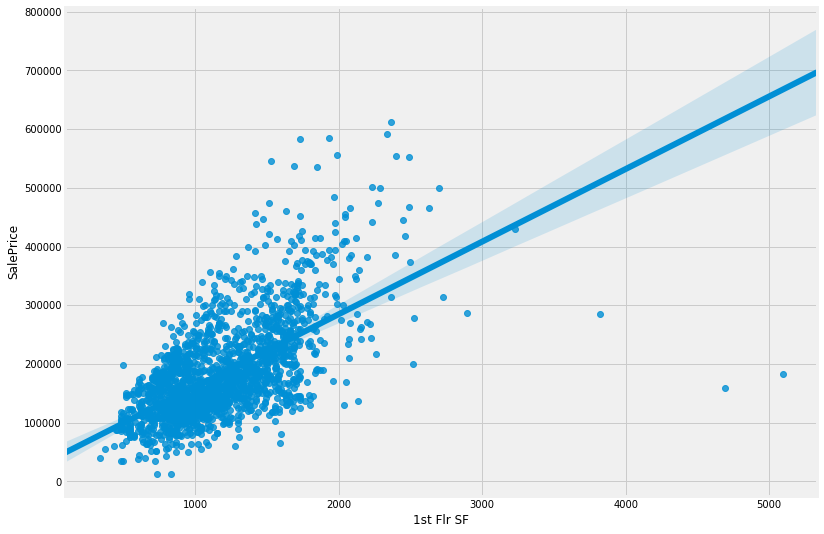

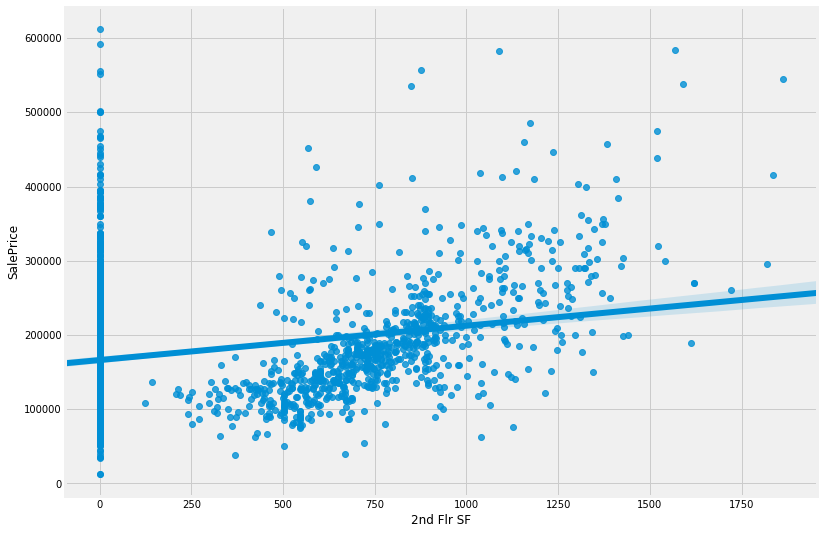

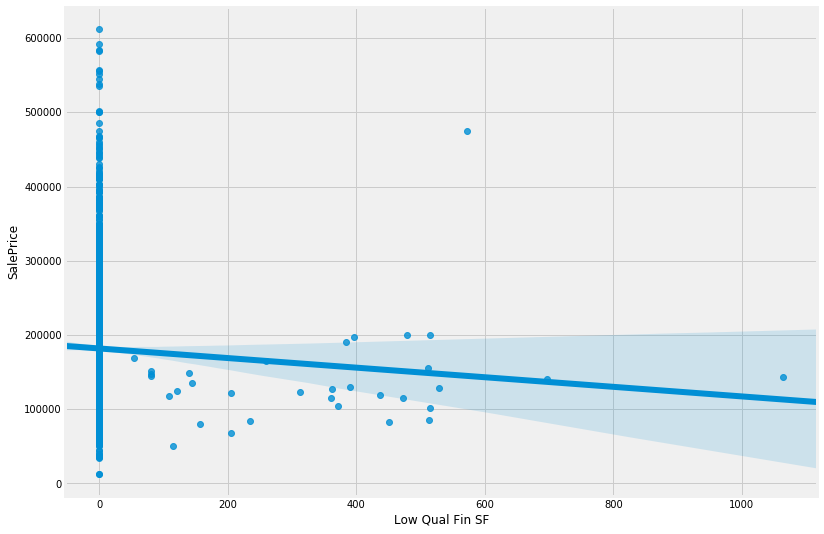

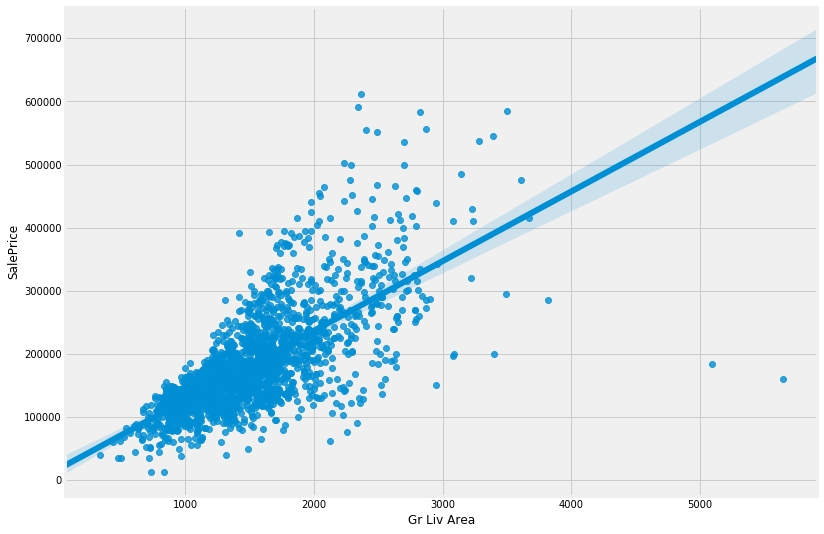

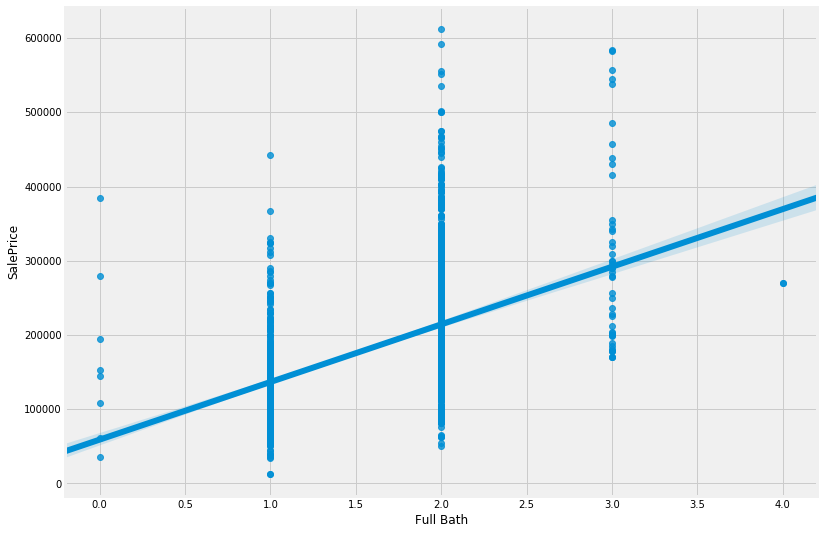

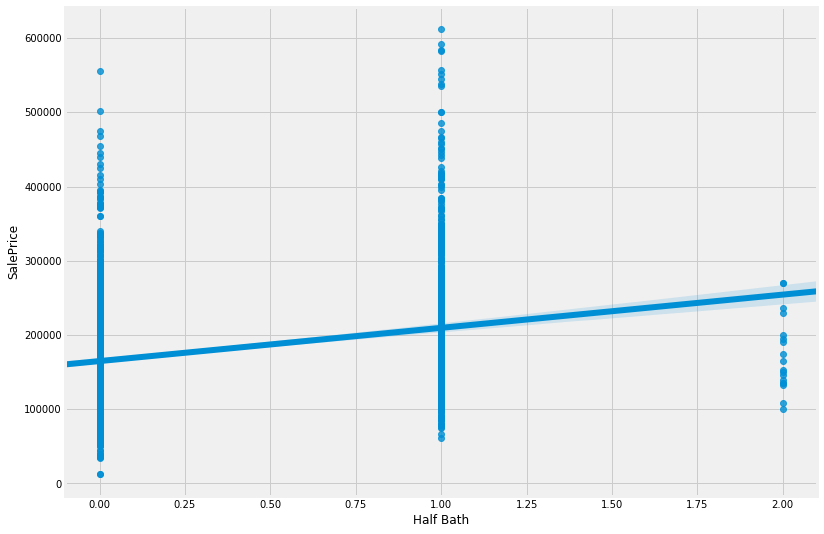

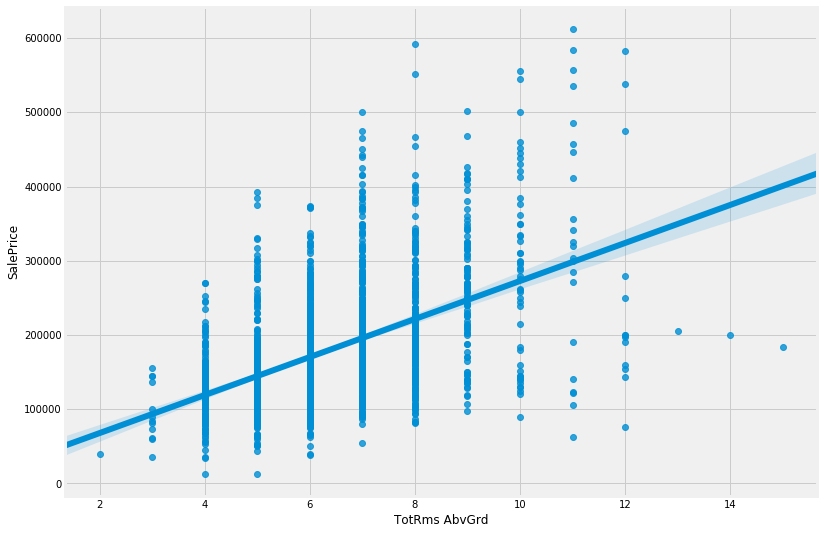

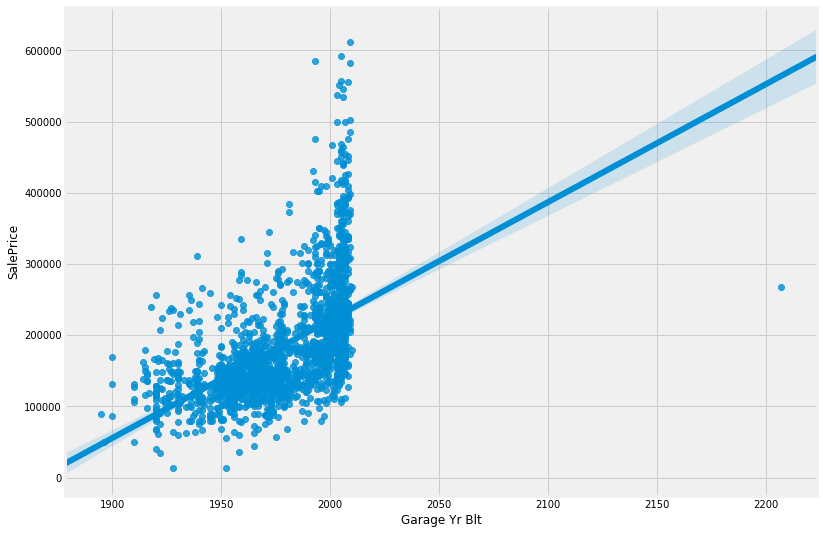

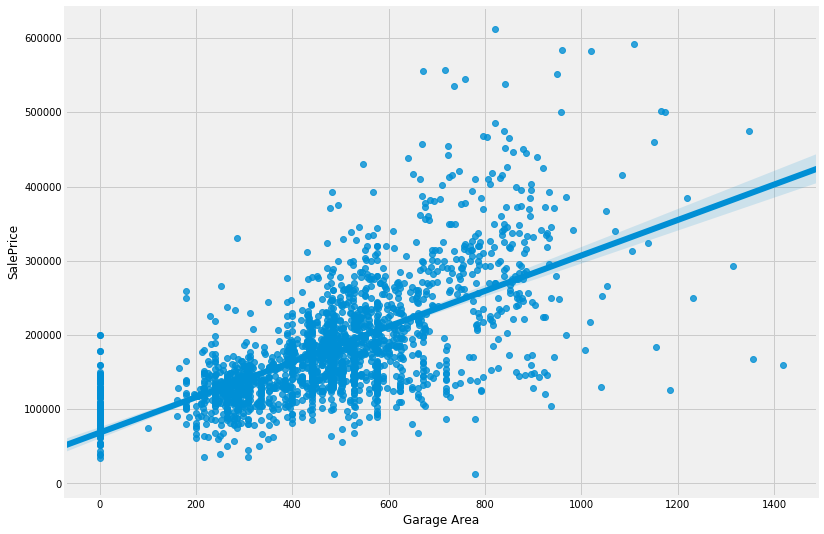

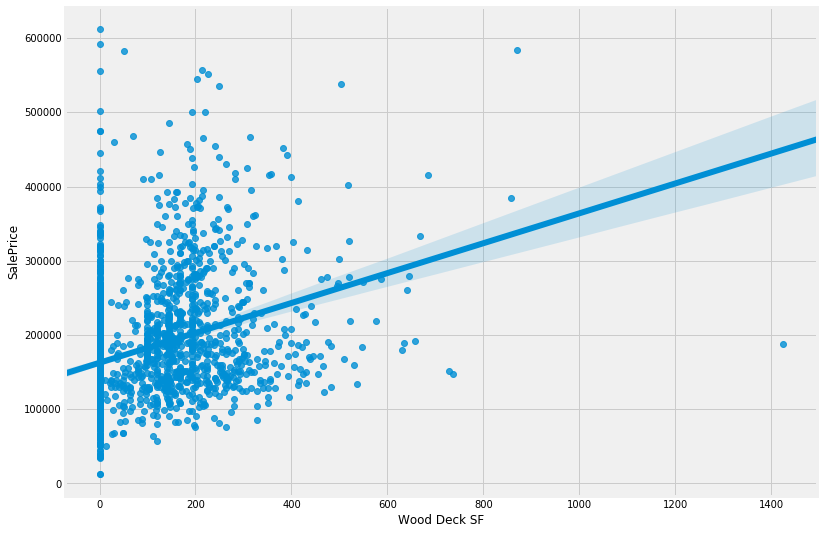

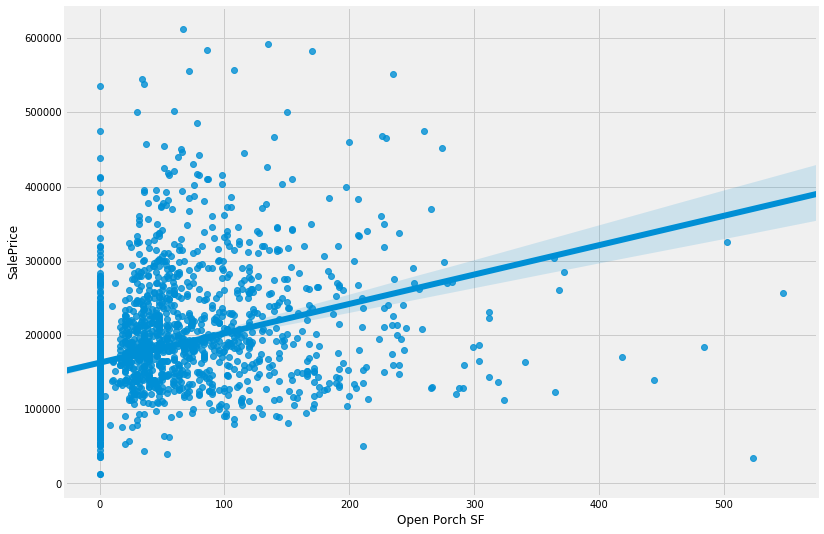

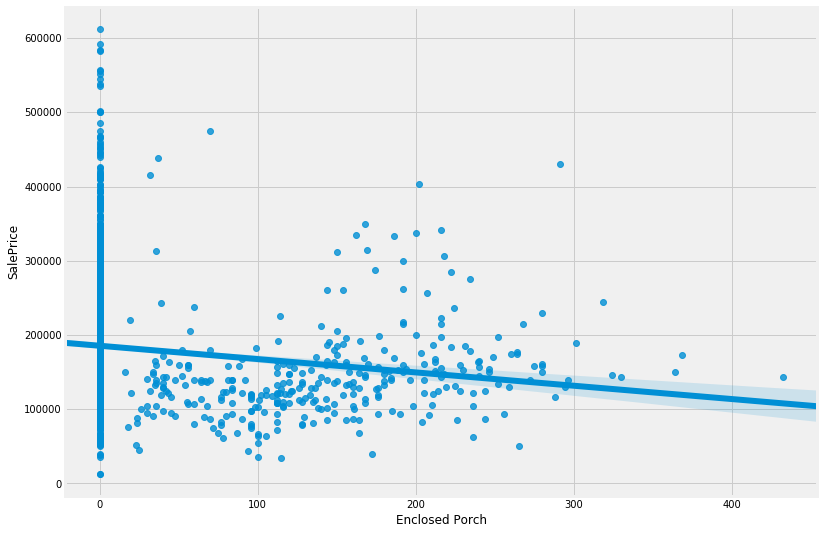

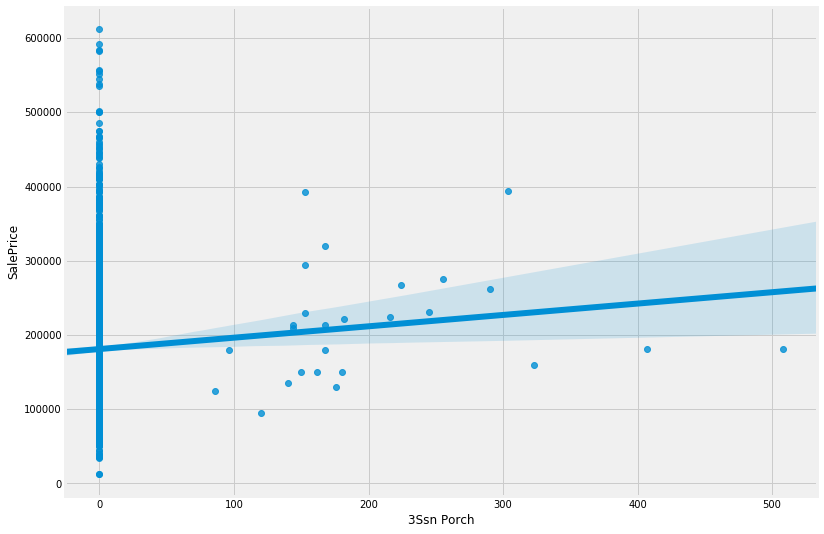

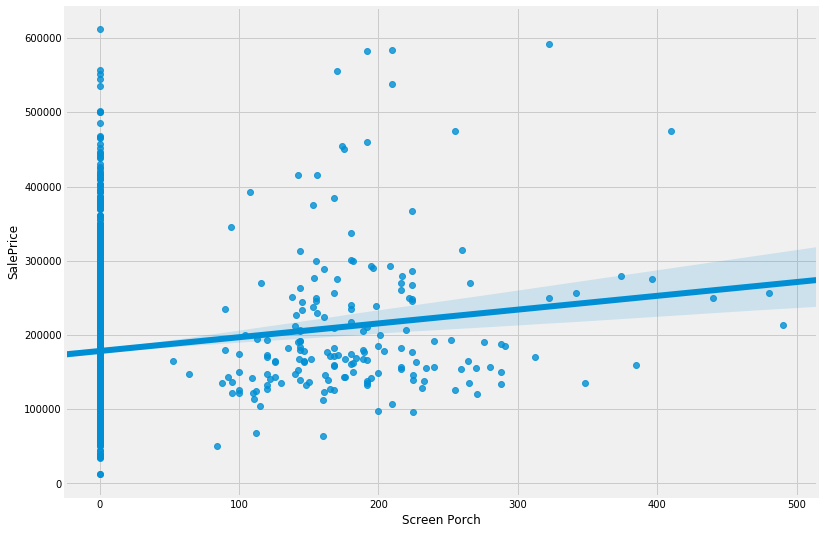

In [9]:
# Graph continous variables against SalePrice
cont_variables = [col for col in df.columns if 'SF'  in col or col in ['Full Bath','Half Bath','TotRms AbvGrd','Lot Frontage', 'Lot Area','Year Built',
                                                              'Year Remod/Add','Mas Vnr Area',
                                                              'Garage Yr Blt', 'Gr Liv Area', 'Screen Porch',
                                                              'Garage Area','3Ssn Porch','Enclosed Porch']]
for col in cont_variables:
    plt.figure(figsize=(12,9))
    sns.regplot(col,'SalePrice', data = df);

C:\Users\pauls\Anaconda3\envs\dsi\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


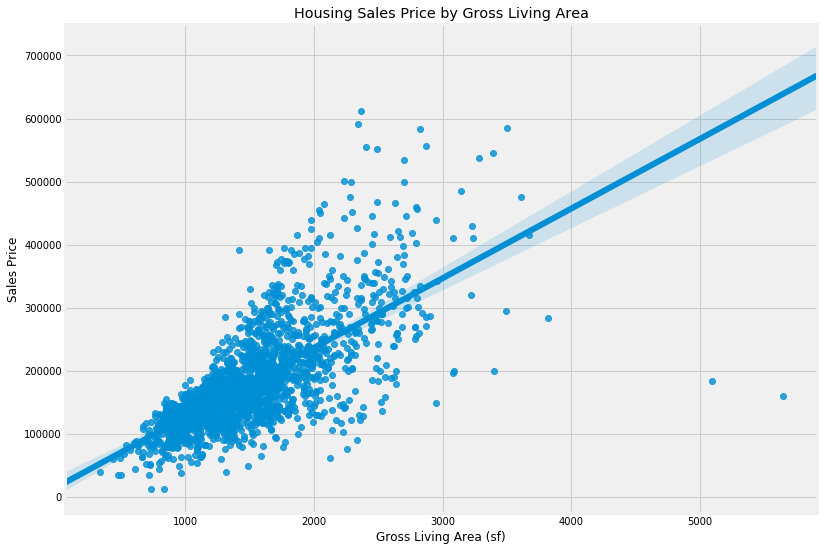

In [10]:
plt.figure(figsize=(12,9))
sns.regplot('Gr Liv Area','SalePrice', data = df)
plt.xlabel('Gross Living Area (sf)')
plt.ylabel('Sales Price')
plt.title('Housing Sales Price by Gross Living Area')
plt.savefig('salesbylivingarea.png');

C:\Users\pauls\Anaconda3\envs\dsi\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Housing Sales Price by Gross Living Area')

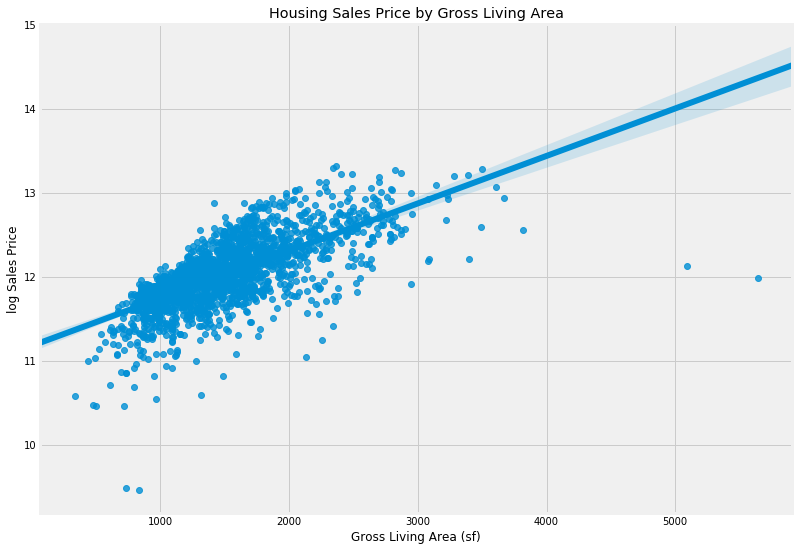

In [11]:
# relationship is more linear with the log of SalePrice, but there are still outliers
df['l_saleprice'] = np.log(df['SalePrice'])
plt.figure(figsize=(12,9))
sns.regplot('Gr Liv Area','l_saleprice', data = df)
plt.xlabel('Gross Living Area (sf)')
plt.ylabel('log Sales Price')
plt.title('Housing Sales Price by Gross Living Area')
# plt.savefig('salesbylivingarea.png');

In [12]:
# There are two outliers with more than 5,000 sf -- but nothing suggests that there is an error:
# they have big basements, big 1st floors, and are recently built
pd.options.display.max_rows = 500
mask = (df['Gr Liv Area']>5000)
df[mask].T

,960,1885
Id,1499,2181
PID,908154235,908154195
MS SubClass,60,20
MS Zoning,RL,RL
Lot Frontage,313,128
Lot Area,63887,39290
Street,Pave,Pave
Alley,NaN,NaN
Lot Shape,IR3,IR1
Land Contour,Bnk,Bnk


C:\Users\pauls\Anaconda3\envs\dsi\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


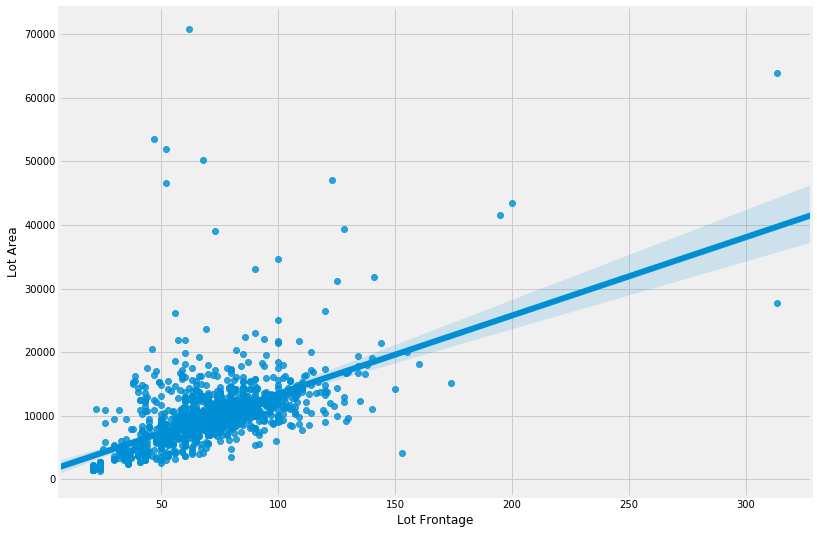

In [13]:
# graph Frontage vs. Area
plt.figure(figsize=(12,9))
sns.regplot('Lot Frontage','Lot Area', data = df);

Lot Frontage has 330 missing values. We can create a regression model to use Lot Area to impute missing values of Lot Frontage. 
  - However, it turns out that Lot Frontage does not add to the model as a continuous variable.
  - Instead I created a dummy for Lot Frontage < 35 ft, because Ames Zoning generally requires a min. of 35 ft of frontage for residential uses. (There were a few cases of lot frontage as little as 21 ft. in the training data.)

In [14]:
# regress Lot Area against Lot Frontage to find function to impute missing values
# first create data set with no missing Lot Frontage
LotArea = df[df['Lot Frontage'].notna()]
impute_frontage = LinearRegression()
LotArea['lot_area_sq'] = LotArea['Lot Area']**2 # did not include in final model; does not add much
LotArea['lot_area_sqrt'] = LotArea['Lot Area']**.5
X_impute = LotArea[['Lot Area','lot_area_sqrt']]
y_impute = LotArea['Lot Frontage']
impute_frontage.fit(X_impute,y_impute)
impute_frontage.score(X_impute,y_impute)

C:\Users\pauls\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\pauls\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0.44921595379667717

In [15]:
# create new column with imputed values filling nulls in Lot Frontage
a = impute_frontage.intercept_
b1 = impute_frontage.coef_[0]
b2 = impute_frontage.coef_[1]
df['lot_frontage_imputed'] = df['Lot Frontage']
df['lot_area_sqrt'] = df['Lot Area']**.5
df['lot_frontage_imputed'] = df['lot_frontage_imputed'].fillna(a + b1 * df['Lot Area'] + b2 * df['lot_area_sqrt'])

In [16]:
df['Lot Frontage'].describe()

count    1721.000000
mean       69.055200
std        23.260653
min        21.000000
25%        58.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: Lot Frontage, dtype: float64

I used the mean SalesPrice for each category, and the plots of SalesPrice x continuous variables, to transform and select variables:

In [17]:
# variable transformations
def transform(df):
    df['culdesac'] = df['Lot Config'].apply(lambda x: 1 if x == 'CulDSac' else 0)
    df['fancysuburb'] = df['Neighborhood'].apply(lambda x: 1 if x in ['GrnHill','NoRidge','NridgHt','StoneBr'] else 0)
    df['suburb'] = df['Neighborhood'].apply(lambda x: 1 if x in ['Blmngtn','ClearCr','CollgCr','Crawfor','Gilbert',
                                                             'Greens','NWAmes','SawyerW','Somerst','Timber',
                                                             'Veenker','Mitchel'] else 0)
    df['near_road'] = df['Condition 1'].apply(lambda x: 1 if x in ['Artery','Feedr'] else 0)
    df['bad_qual'] = df['Overall Qual'].apply(lambda x: 1 if x < 4 else 0)
    df['exc_qual'] = df['Overall Qual'].apply(lambda x: 1 if x > 8 else 0)
    df['good_qual'] = df['Overall Qual'].apply(lambda x: 1 if  x == 7 else 0)
    df['very_good_qual'] = df['Overall Qual'].apply(lambda x: 1 if x == 8 else 0)
    df['below_avg_qual'] = df['Overall Qual'].apply(lambda x: 1 if x == 4 else 0) # 5 = average - reference case
    df['above_avg_qual'] = df['Overall Qual'].apply(lambda x: 1 if x == 6 else 0)
    df['lot_ar_sq'] = df['Lot Area']**2
    df['lot_ar_cu'] = df['Lot Area']**3
    df['live_ar_sq'] = df['Gr Liv Area']**2
    df['live_ar_cu'] = df['Gr Liv Area']**3
    df['year_built_sq'] = df['Year Built']**2
    df['frontageLT35'] = df['Lot Frontage'].apply(lambda x: 1 if x <35 else 0)
    df['frontageLT50'] = df['Lot Frontage'].apply(lambda x: 1 if 35 <= x < 50 else 0)
    df['ac'] = df['Central Air'].apply(lambda x: 1 if x =='Y' else 0)
    df['zoning'] = df['MS Zoning'].apply(lambda x: 1 if x in ['FV','RL'] else 0)
    df['concrete'] = df['Foundation'].apply(lambda x: 1 if x == 'PConc' else 0)
    df['exc_basement'] = df['Bsmt Qual'].apply(lambda x: 1 if x == 'Ex' else 0)
    df['new'] = df['Year Built'].apply(lambda x: 1 if x > 2005 else 0)
    df['remodel'] = df['Year Remod/Add'].apply(lambda x: 1 if x > 2005 else 0)
    df['new_const'] = df['Sale Type'].apply(lambda x: 1 if x == 'New' else 0)
    df['exc_kitchen'] = df['Kitchen Qual'].apply(lambda x: 1 if x == 'Ex' else 0)
    df['good_kitchen'] = df['Kitchen Qual'].apply(lambda x: 1 if x == 'Gd' else 0)
    df['num_cars'] = df['Garage Cars'].apply(lambda x: 2 if x == 5 else x) # the single case with 5 seems to be an error
    df['damage'] = df['Functional'].apply(lambda x: 0 if x == 'Typ' else 1)
    df['num_cars'] = df['num_cars'].replace(np.NaN, 0)
    df['0_garage'] = df['num_cars'].apply(lambda x: 1 if x == 0 else 0)
    df['1_garage'] = df['num_cars'].apply(lambda x: 1 if x == 1 else 0)
    df['3_garage'] = df['num_cars'].apply(lambda x: 1 if x == 3 else 0)
    df['4_garage'] = df['num_cars'].apply(lambda x: 1 if x == 4 else 0)    
    df['bad_condition'] = df['Overall Cond'].apply(lambda x: 1 if x <5 else 0)
    df['good_basement'] = df['Bsmt Qual'].apply(lambda x: 1 if x == 'Gd' else 0)
    df['old_1story'] = df['MS SubClass'].apply(lambda x: 1 if x ==  30 else 0)
    df['new_2story'] = df['MS SubClass'].apply(lambda x: 1 if x ==  60 else 0)
    df['hill'] = df['Land Contour'].apply(lambda x: 1 if x == 'HLS' else 0)
    df['corner'] = df['Lot Config'].apply(lambda x: 1 if x == 'Corner' else 0)
    df['near_artery'] = df['Condition 1'].apply(lambda x: 1 if x == 'Artery' else 0)
    df['near_feeder'] = df['Condition 1'].apply(lambda x: 1 if x == 'Feedr' else 0)
    df['near_park'] = df['Condition 1'].apply(lambda x: 1 if x in ['PosA','PosN'] else 0)
    df['hip_roof'] = df['Roof Style'].apply(lambda x: 1 if x == 'Hip' else 0)
    df['l_lot_area'] = np.log(df['Lot Area'])
    df['attached_garage'] =  df['Garage Type'].apply(lambda x: 1 if x in ['Attchd','BuiltIn'] else 0)
    df['full_bath_0'] = df['Full Bath'].apply(lambda x: 1 if x == 0 else 0) 
    df['full_bath_2'] = df['Full Bath'].apply(lambda x: 1 if x == 2 else 0)
    df['full_bath_3'] = df['Full Bath'].apply(lambda x: 1 if x == 3 else 0)
    df['full_bath_4'] = df['Full Bath'].apply(lambda x: 1 if x > 3 else 0)
    df['half_bath_1'] = df['Half Bath'].apply(lambda x: 1 if x == 1 else 0) 
    df['half_bath_2'] = df['Half Bath'].apply(lambda x: 1 if x > 1 else 0)
    df['breakers'] = df['Electrical'].apply(lambda x: 1 if x == 'SBrkr' else 0)
    df['unf_garage']=df['Garage Finish'].apply(lambda x: 1 if x == 'Unf' else 0)
    df['paved_driveway']=df['Paved Drive'].apply(lambda x: 1 if x == 'Y' else 0)
    df['two_fam']=df['Bldg Type'].apply(lambda x: 1 if x in ['2fmCon','Duplex','Twnhs'] else 0)
    df['two_story']=df['House Style'].apply(lambda x: 1 if x in ['2Story','2.5Fin','2.5Unf'] else 0)
    df['l_living_area'] = np.log(df['Gr Liv Area'])
    df['2010'] = df['Yr Sold'].apply(lambda x: 1 if x == 2010 else 0) # reference is 2006
    df['2009'] = df['Yr Sold'].apply(lambda x: 1 if x == 2009 else 0)
    df['2008'] = df['Yr Sold'].apply(lambda x: 1 if x == 2008 else 0)
    df['2007'] = df['Yr Sold'].apply(lambda x: 1 if x == 2007 else 0)
    df['cement_board'] = df['Exterior 1st'].apply(lambda x: 1 if x == 'CemntBd' else 0)
    df['vinyl_siding'] = df['Exterior 1st'].apply(lambda x: 1 if x == 'VinylSd' else 0)
    df['basement_area'] = df['Total Bsmt SF'].replace(np.NaN, 0) # recode single NaN as 0
    
    

# these have missing values
# df['exc_exter'] = df['Exter Qual'].apply(lambda x: 1 if x == 'Ex' else 0)
# df['good_exter'] = df['Exter Qual'].apply(lambda x: 1 if x == 'Gd' else 0)
# df['bsmt_exposure'] = df['Bsmt Exposure'].apply(lambda x: 1 if x == 'Gd' else 0)
# df['fancy_bsmt'] = df['BsmtFin Type 1'].apply(lambda x: 1 if x == 'GLQ' else 0)

In [18]:
# I tried making each Neighborhood into a separate dummy, but there is not enough data on each one
# to get separtate coefficient estimates -- the 3 category system (FancySuburb, Suburb, all other) seems to
# work better
# dummies = pd.get_dummies(df.Neighborhood)
# df = pd.concat([df, dummies], axis=1)
# Neighborhoods = [name for name in dummies.columns]
# Neighborhoods.remove('NAmes')  # drop reserved case

In [19]:
# run all of the above transformations on the training data:
transform(df)

In [20]:
# Set list of features to use in model
features = ['Gr Liv Area','live_ar_sq','basement_area', # living area
            'Lot Area', 'frontageLT35',                 # Lot area and frontage
            'TotRms AbvGrd','Bedroom AbvGr','full_bath_0','full_bath_2','full_bath_3','half_bath_1','half_bath_2',  # number of rooms
            'hill','culdesac','fancysuburb','suburb','near_artery','near_feeder','near_park',  # location
            'Year Built', 'hip_roof','two_fam','two_story','zoning',  # house type and style
            'ac','Fireplaces', 'breakers','unf_garage','num_cars','paved_driveway','concrete', # amenities
            'exc_qual','very_good_qual','good_qual','above_avg_qual','below_avg_qual','bad_qual', # overall quality
            'exc_basement','remodel','exc_kitchen','good_kitchen','damage','bad_condition', # condition
            '2009','2010']               # year sold
# omitted: 'new','attached_garage', ','old_1story','new_const','corner','lot_ar_sq','total_baths',
# 'year_built_sq','good_basement','0_garage','1_garage','3_garage','4_garage'
# 'live_ar_cu','lot_ar_sq','lot_ar_cu',

# set X and Y for full training sample
X = df[features]
y = df['SalePrice']

In [21]:
# remove very big houses (outliers)
mask = (df['Gr Liv Area']<4000)
df = df[mask]

In [22]:
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)

0.8849221476358223

In [23]:
# try model with non-missing Lot Frontage -- adds almost nothing to the model (especially in log-linear form)

non_miss = df[pd.notnull(df['Lot Frontage'])]
features_frontage = features.copy()
features_frontage.append('Lot Frontage')  # add Lot Frontage to list of features
X = non_miss[features_frontage]
y = np.log(non_miss['SalePrice'])
X = sm.add_constant(X)
model = sm.OLS(y,X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     343.2
Date:                Sun, 24 Mar 2019   Prob (F-statistic):               0.00
Time:                        14:45:11   Log-Likelihood:                 1041.4
No. Observations:                1719   AIC:                            -1989.
Df Residuals:                    1672   BIC:                            -1733.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              9.6594      0.441     21.

In [24]:
# log linear model
df['l_price'] = np.log(df['SalePrice'])
y=df['l_price']
X = df[features]
X = sm.add_constant(X)
model = sm.OLS(y,X).fit()
basemodel = model.summary()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                l_price   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     387.8
Date:                Sun, 24 Mar 2019   Prob (F-statistic):               0.00
Time:                        14:45:12   Log-Likelihood:                 1241.4
No. Observations:                2049   AIC:                            -2391.
Df Residuals:                    2003   BIC:                            -2132.
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              9.2885      0.414     22.

In [35]:
# save model results to html tables
base_overview = basemodel.tables[0].as_html()
base_overview.replace('\n','')   # remove '\n'

'<table class="simpletable"><caption>OLS Regression Results</caption><tr>  <th>Dep. Variable:</th>         <td>l_price</td>     <th>  R-squared:         </th> <td>   0.897</td></tr><tr>  <th>Model:</th>                   <td>OLS</td>       <th>  Adj. R-squared:    </th> <td>   0.895</td></tr><tr>  <th>Method:</th>             <td>Least Squares</td>  <th>  F-statistic:       </th> <td>   387.8</td></tr><tr>  <th>Date:</th>             <td>Sun, 24 Mar 2019</td> <th>  Prob (F-statistic):</th>  <td>  0.00</td> </tr><tr>  <th>Time:</th>                 <td>14:45:12</td>     <th>  Log-Likelihood:    </th> <td>  1241.4</td></tr><tr>  <th>No. Observations:</th>      <td>  2049</td>      <th>  AIC:               </th> <td>  -2391.</td></tr><tr>  <th>Df Residuals:</th>          <td>  2003</td>      <th>  BIC:               </th> <td>  -2132.</td></tr><tr>  <th>Df Model:</th>              <td>    45</td>      <th>                     </th>     <td> </td>   </tr><tr>  <th>Covariance Type:</th>    

In [36]:
base_coeffs = basemodel.tables[1].as_html()
base_coeffs.replace('\n','')   # remove '\n'

'<table class="simpletable"><tr>         <td></td>           <th>coef</th>     <th>std err</th>      <th>t</th>      <th>P>|t|</th>  <th>[0.025</th>    <th>0.975]</th>  </tr><tr>  <th>const</th>          <td>    9.2885</td> <td>    0.414</td> <td>   22.427</td> <td> 0.000</td> <td>    8.476</td> <td>   10.101</td></tr><tr>  <th>Gr Liv Area</th>    <td>    0.0005</td> <td> 4.03e-05</td> <td>   11.211</td> <td> 0.000</td> <td>    0.000</td> <td>    0.001</td></tr><tr>  <th>live_ar_sq</th>     <td>-4.229e-08</td> <td> 9.69e-09</td> <td>   -4.365</td> <td> 0.000</td> <td>-6.13e-08</td> <td>-2.33e-08</td></tr><tr>  <th>basement_area</th>  <td>    0.0001</td> <td> 1.11e-05</td> <td>   10.998</td> <td> 0.000</td> <td>    0.000</td> <td>    0.000</td></tr><tr>  <th>Lot Area</th>       <td> 3.582e-06</td> <td> 5.29e-07</td> <td>    6.765</td> <td> 0.000</td> <td> 2.54e-06</td> <td> 4.62e-06</td></tr><tr>  <th>frontageLT35</th>   <td>   -0.0488</td> <td>    0.017</td> <td>   -2.808</td> <td> 0.0

### Save feature list, transform function, and regression results using Dill (pickle)

In [27]:
# save feature list
with open('features', 'wb') as f:
    pickle.dump(features, f)

In [28]:
# save model results
pickle.dump(model, open('basemodel.sav', 'wb'))

## Read in test data and create predictions to submit to Kaggle using base model.

In [29]:
test = pd.read_csv('./datasets/test.csv')

In [30]:
test.isna().sum()

Id                   0
PID                  0
MS SubClass          0
MS Zoning            0
Lot Frontage       160
Lot Area             0
Street               0
Alley              821
Lot Shape            0
Land Contour         0
Utilities            0
Lot Config           0
Land Slope           0
Neighborhood         0
Condition 1          0
Condition 2          0
Bldg Type            0
House Style          0
Overall Qual         0
Overall Cond         0
Year Built           0
Year Remod/Add       0
Roof Style           0
Roof Matl            0
Exterior 1st         0
Exterior 2nd         0
Mas Vnr Type         1
Mas Vnr Area         1
Exter Qual           0
Exter Cond           0
Foundation           0
Bsmt Qual           25
Bsmt Cond           25
Bsmt Exposure       25
BsmtFin Type 1      25
BsmtFin SF 1         0
BsmtFin Type 2      25
BsmtFin SF 2         0
Bsmt Unf SF          0
Total Bsmt SF        0
Heating              0
Heating QC           0
Central Air          0
Electrical 

In [37]:
test.shape

(879, 144)

In [40]:
879*.3

263.7

In [31]:
transform(test)

In [32]:
X_test = X[features]
X_test = sm.add_constant(X_test)

In [33]:
test['SalePrice'] = np.exp(model.predict(X_test))

In [34]:
submit = test[['Id','SalePrice']]
submit.to_csv('submit1.csv',index=False)